In [1]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [20]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [21]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [23]:
files = glob('Cappello/Cinnabar_Hydrocerussite/roi*.dat')
cnb_hcs = MixPhase([cinnabar,hydrocerussite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(cnb_hcs,spectra)]

N mixtures: 3
[-1134.82883579    49.14584499  1999.54863044]
[-1173.36360625    50.38935486  1976.33024052]
[-1163.3896009     50.16881588  1976.7146904 ]


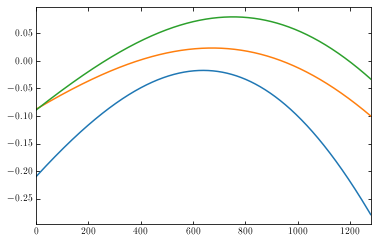

In [24]:
all_cinnabar = database['Cinnabar']
all_hydrocerussite = database['Hydrocerussite']
sb = []
for cinnabar in all_cinnabar:
    for hydrocerussite in all_hydrocerussite:
        sb += [MixPhase([cinnabar,hydrocerussite])]
print('N mixtures:',len(sb))

x = arange(1280)
gn = []
for phase in sb:
    gn += [GaussNewton(phase,xrd_spectra[0])]
    
for g in gn[:]:
    for _ in range(64):
        g.calibration(alpha=1)
        g.opt = g.spectra.opt.copy()
    print(g.spectra.opt)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

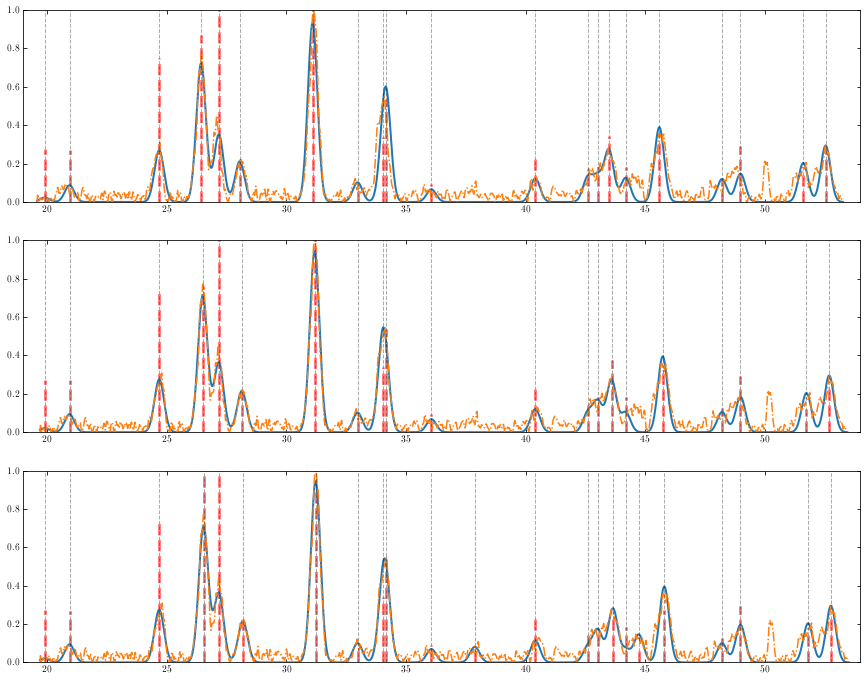

In [25]:
%matplotlib inline
fig,ax = subplots(3,1,figsize = (15,12))

for i,g in enumerate(gn[:]):
    
    g.spectra.opt = g.opt.copy()
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(g.spectra.theta,g.spectra.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[0.70863936 0.91256575 1.04439337 1.32745051 1.19905702 1.6769865
 1.44350722 1.39875952 1.29735361 0.07596286 0.3479496  0.366374
 0.36073436 1.15626103 0.77914091 0.57545673 0.75333895 0.46871236
 0.53523486 0.91075508 0.36534773 0.79233249 0.67005955]


(19.0, 53.0)

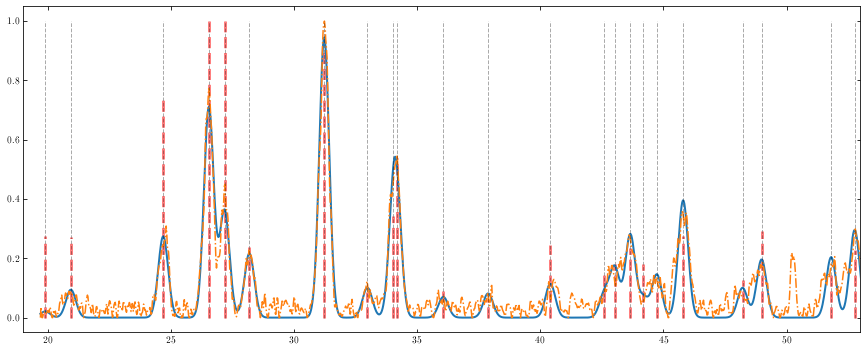

In [26]:
g = xrd_gn[0]
s = xrd_spectra[0]

for _ in range(32):
    g.calibration(alpha=1)  
print(g.gamma)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(g.spectra.theta,g.spectra.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

xlim(19,53)
#ylim(0,1)

[-1163.3896009     50.16881588  1976.7146904 ]
[-1171.48901603    50.81530323  1956.65139293]
[-1171.24364345    50.44240561  1967.05704575]
[-1174.47843211    50.80960548  1963.37074604]
[-1170.00239758    50.69363654  1961.28455656]
[-1173.03871937    50.6637889   1957.89612154]
[-1165.70207108    50.73211179  1954.10604612]
[-1173.62756453    50.9846697   1948.02924761]


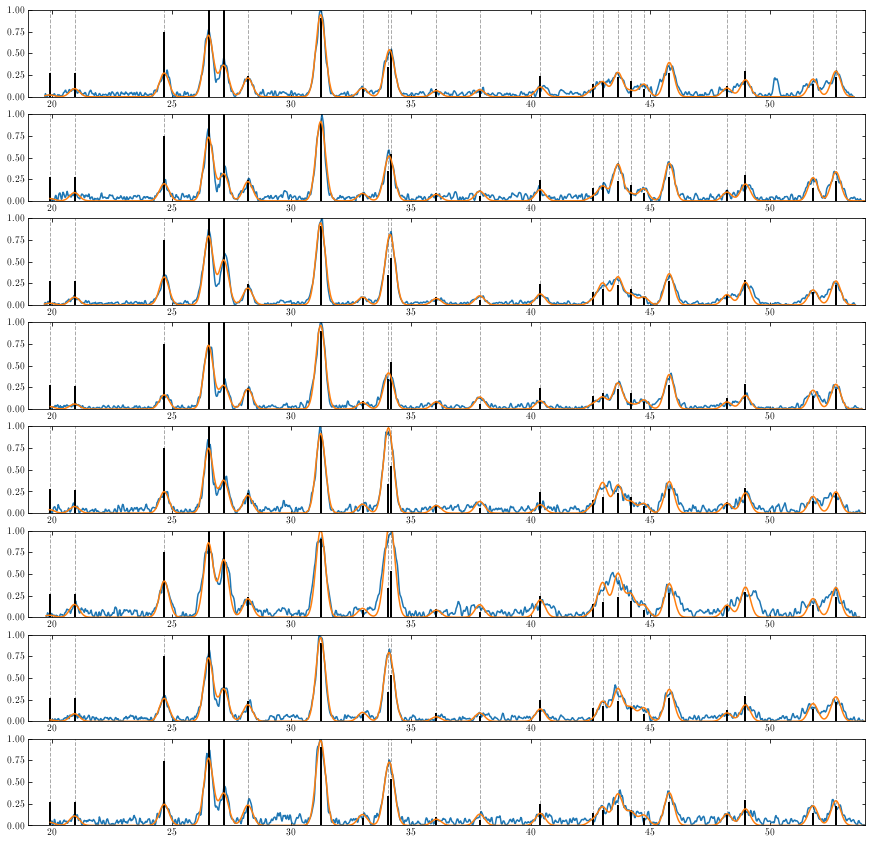

In [29]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration(alpha=0.5)
    print(gn.spectra.opt)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.05)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1163.3896009     50.16881588  1976.7146904 ] [-1214.71937795    51.66346478  1952.71389334]
[-1171.48901603    50.81530323  1956.65139293] [-1214.71937795    51.66346478  1952.71389334]
[-1171.24364345    50.44240561  1967.05704575] [-1214.71937795    51.66346478  1952.71389334]
[-1174.47843211    50.80960548  1963.37074604] [-1214.71937795    51.66346478  1952.71389334]
[-1170.00239758    50.69363654  1961.28455656] [-1214.71937795    51.66346478  1952.71389334]
[-1173.03871937    50.6637889   1957.89612154] [-1214.71937795    51.66346478  1952.71389334]
[-1165.70207108    50.73211179  1954.10604612] [-1214.71937795    51.66346478  1952.71389334]
[-1173.62756453    50.9846697   1948.02924761] [-1214.71937795    51.66346478  1952.71389334]


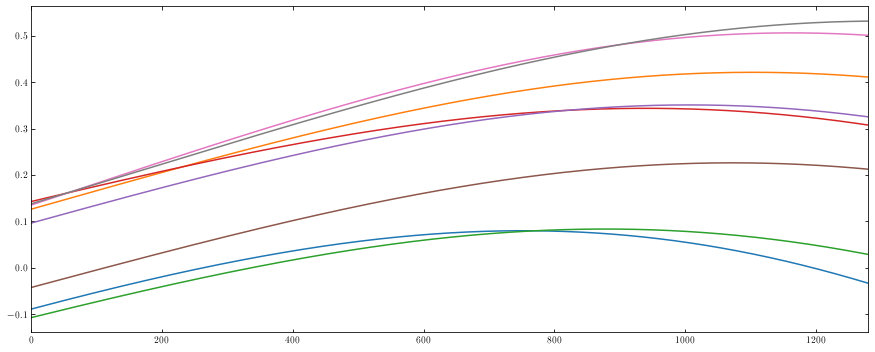

In [30]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)
